## Libraries:

In [1]:
# --- System and Utility Libraries ---
import os
import math
import copy
import tempfile
import warnings
import calendar
import requests

# --- Scientific Computing ---
import numpy as np
import pandas as pd
import xarray as xr
import scipy.ndimage

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- TensorFlow & Keras ---
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import (
    Input, Add, LSTM, Dense, Reshape, LeakyReLU,
    ConvLSTM2D, BatchNormalization, Conv3D,
    Dropout, SpatialDropout3D
)
from tensorflow.keras.models import Sequential, Model

# --- Scikit-learn: Preprocessing & Metrics ---
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    accuracy_score, classification_report, confusion_matrix
)

# --- Statistical Analysis ---
from scipy.stats import pearsonr


## Data Loading and Preprocessing

- The training and testing datasets are loaded directly from Google Drive as .npy files. These files were generated by the `Data_Pipeline.ipynb` notebook and consist of spatiotemporal climate data blocks derived from the ERA5 reanalysis dataset, paired with corresponding SPEI (Standardized Precipitation-Evapotranspiration Index) targets.

- For detailed information on the construction of these datasets, refer to the `Data_Pipeline` and `Download_SPEIData` scripts available in the project's GitHub repository.

- Training Data spans the years 1999 to 2001, and is used to fit and validate the forecasting models.

- Testing Data is drawn from the year 2002 and is used strictly for out-of-sample model evaluation.

- Each data sample represents a spatial-temporal block composed of 31 consecutive days of ERA5 climate variables over a 20×20 grid region in Australia.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- Load Data ---
# Training Data
train_X = np.load('/content/drive/My Drive/ST456/raw_train_X_combined.npy')
train_y = np.load('/content/drive/My Drive/ST456/raw_train_y_combined.npy')
# Testing Data
test_X = np.load('/content/drive/MyDrive/ST456/raw_test_X.npy')
test_y = np.load('/content/drive/MyDrive/ST456/raw_test_y.npy')

#### Missing Value Handling (Replacing -9999 and Interpolating NaNs)
- Missing or padded data (e.g., due to edge blocks or incomplete months) is filled with a placeholder value of -9999. This value must be converted to NaN in order to be properly handled by interpolation and ignored during masked loss computation.
- We then interpolate the missing values using a linear method. This ensures that:
    - Temporal and spatial continuity is preserved, allowing the model to learn smooth dynamics.
    - The deep learning model receives no hard discontinuities or outliers (which would break convergence).
    - We're not discarding large amounts of data that might otherwise be lost if we masked entire blocks or time steps.

This step is particularly important because models like ConvLSTM rely on coherent sequences to detect spatial-temporal patterns.

In [5]:
# --- Handle Missing Values ---
# Replace -9999 with NaN in the data
train_X[train_X == -9999] = np.nan
train_y[train_y == -9999] = np.nan

# Interpolate missing values in train_X across samples for each feature/channel
train_X_df = pd.DataFrame(train_X.reshape(-1, train_X.shape[-1]))  # Flatten for interpolation
train_X_df.interpolate(method='linear', axis=0, inplace=True)      # Fill missing values linearly
train_X = train_X_df.values.reshape(train_X.shape)                 # Reshape to original

# Repeat the same for the target variable
train_y_df = pd.DataFrame(train_y.reshape(-1, train_y.shape[-1]))
train_y_df.interpolate(method='linear', axis=0, inplace=True)
train_y = train_y_df.values.reshape(train_y.shape)

#### Pearson Correlation Filtering for Channel Selection
After filling missing values, we compute the Pearson correlation coefficient between each input channel (climate variable) and the SPEI target. The idea is to:
- Quantify how strongly each climate variable is linearly related to the target.
- Keep only the positively correlated features, under the assumption that negatively or weakly correlated inputs may add noise or reduce model signal-to-noise ratio.

By selecting only the most relevant input variables:
- We reduce the dimensionality of the input data.
- The model becomes less complex, which can improve generalization.
- Training becomes faster, and overfitting is less likely.

In [6]:
# --- Channel Selection ---
n_channels = train_X.shape[-1]
correlations = []

# Flatten both inputs and target
X_flat = train_X.reshape(-1, n_channels)
y_flat = train_y.flatten()

for i in range(n_channels):
    valid_mask = ~np.isnan(X_flat[:, i]) & ~np.isnan(y_flat)
    corr, _ = pearsonr(X_flat[valid_mask, i], y_flat[valid_mask])
    correlations.append(corr)

# Print correlation per channel
for i, corr in enumerate(correlations):
    print(f"Channel {i}: Pearson corr with target = {corr:.4f}")


Channel 0: Pearson corr with target = 0.2079
Channel 1: Pearson corr with target = 0.1816
Channel 2: Pearson corr with target = 0.1418
Channel 3: Pearson corr with target = 0.3069
Channel 4: Pearson corr with target = 0.3292
Channel 5: Pearson corr with target = 0.3194
Channel 6: Pearson corr with target = -0.0258
Channel 7: Pearson corr with target = 0.3120
Channel 8: Pearson corr with target = 0.3439
Channel 9: Pearson corr with target = 0.3163
Channel 10: Pearson corr with target = -0.0258
Channel 11: Pearson corr with target = -0.0240
Channel 12: Pearson corr with target = -0.0258


Only the channels with a positive Pearson correlation with the target variable (SPEI) are retained.

In [7]:
# Keep only the channels with positive correlation to SPEI
channels_to_keep = [0, 1, 3, 4, 5, 7, 8, 9]
train_X = train_X[..., channels_to_keep]
test_X = test_X[..., channels_to_keep]

#### Standardization of Inputs and Targets 

Deep learning models perform best when inputs are normalized to have zero mean and unit variance. Standardizing the data ensures:
- Faster and more stable convergence during training.
- Balanced gradients across features, preventing domination by high-magnitude variables.
- Better regularization, because scale-invariant weights can generalize more consistently.

Importantly, the target variable (SPEI) is also standardized before training. This allows the model to operate in a normalized prediction space.

**Consistent Standardization of Test Data (No Data Leakage):**

When normalizing the test set, we use the same StandardScaler objects fitted on the training set. This ensures:

- No information from the test set leaks into the training process (preserving the integrity of validation).
- The model makes predictions on test data that has been scaled using the same distributional assumptions it learned during training.

This is critical for evaluating real-world performance, where unseen data must be processed using only knowledge available from the training phase.



In [8]:
# --- Standardization ---
# Standardize the input data (mean=0, std=1)
scaler_X = StandardScaler()
train_X_standardized = scaler_X.fit_transform(train_X.reshape(-1, train_X.shape[-1]))
train_X_standardized = train_X_standardized.reshape(train_X.shape)

# Standardize the target variable (SPEI)
scaler_y = StandardScaler()
train_y_standardized = scaler_y.fit_transform(train_y.reshape(-1, 1)).reshape(train_y.shape)

In [9]:
# --- Data Quality Checks ---
# Sanity check for missing values after interpolation
print(f"NaNs in train_X after interpolation: {np.isnan(train_X_standardized).sum()}")
print(f"NaNs in train_y after interpolation: {np.isnan(train_y_standardized).sum()}")

# Check if standardization worked — negative values should be present due to zero mean
print(f"Negative values in train_X: {np.any(train_X_standardized < 0)}")
print(f"Negative values in train_y: {np.any(train_y_standardized < 0)}")


NaNs in train_X after interpolation: 0
NaNs in train_y after interpolation: 0
Negative values in train_X: True
Negative values in train_y: True


In [10]:
# --- Testing Data ---
# Applying the same preprocessing to the test set

# Replace -9999 with NaN in test set
test_X[test_X == -9999] = np.nan
test_y[test_y == -9999] = np.nan

# Interpolate missing values
test_X_df = pd.DataFrame(test_X.reshape(-1, test_X.shape[-1]))
test_X_df.interpolate(method='linear', axis=0, inplace=True)
test_X = test_X_df.values.reshape(test_X.shape)

test_y_df = pd.DataFrame(test_y.reshape(-1, test_y.shape[-1]))
test_y_df.interpolate(method='linear', axis=0, inplace=True)
test_y = test_y_df.values.reshape(test_y.shape)

# Normalize test data using the training statistics (avoid leakage)
test_X_standardized = scaler_X.transform(test_X.reshape(-1, test_X.shape[-1]))
test_X_standardized = test_X_standardized.reshape(test_X.shape)

test_y_standardized = scaler_y.transform(test_y.reshape(-1, 1)).reshape(test_y.shape)


## Exploratory Data Analysis

Visualizing the distribution of the data is a crucial step in understanding its statistical properties, detecting anomalies, and validating preprocessing steps such as normalization. This section plots histograms for both the standardized target variable (SPEI) and each of the input features (climate channels) to verify they follow expected distributions after preprocessing.

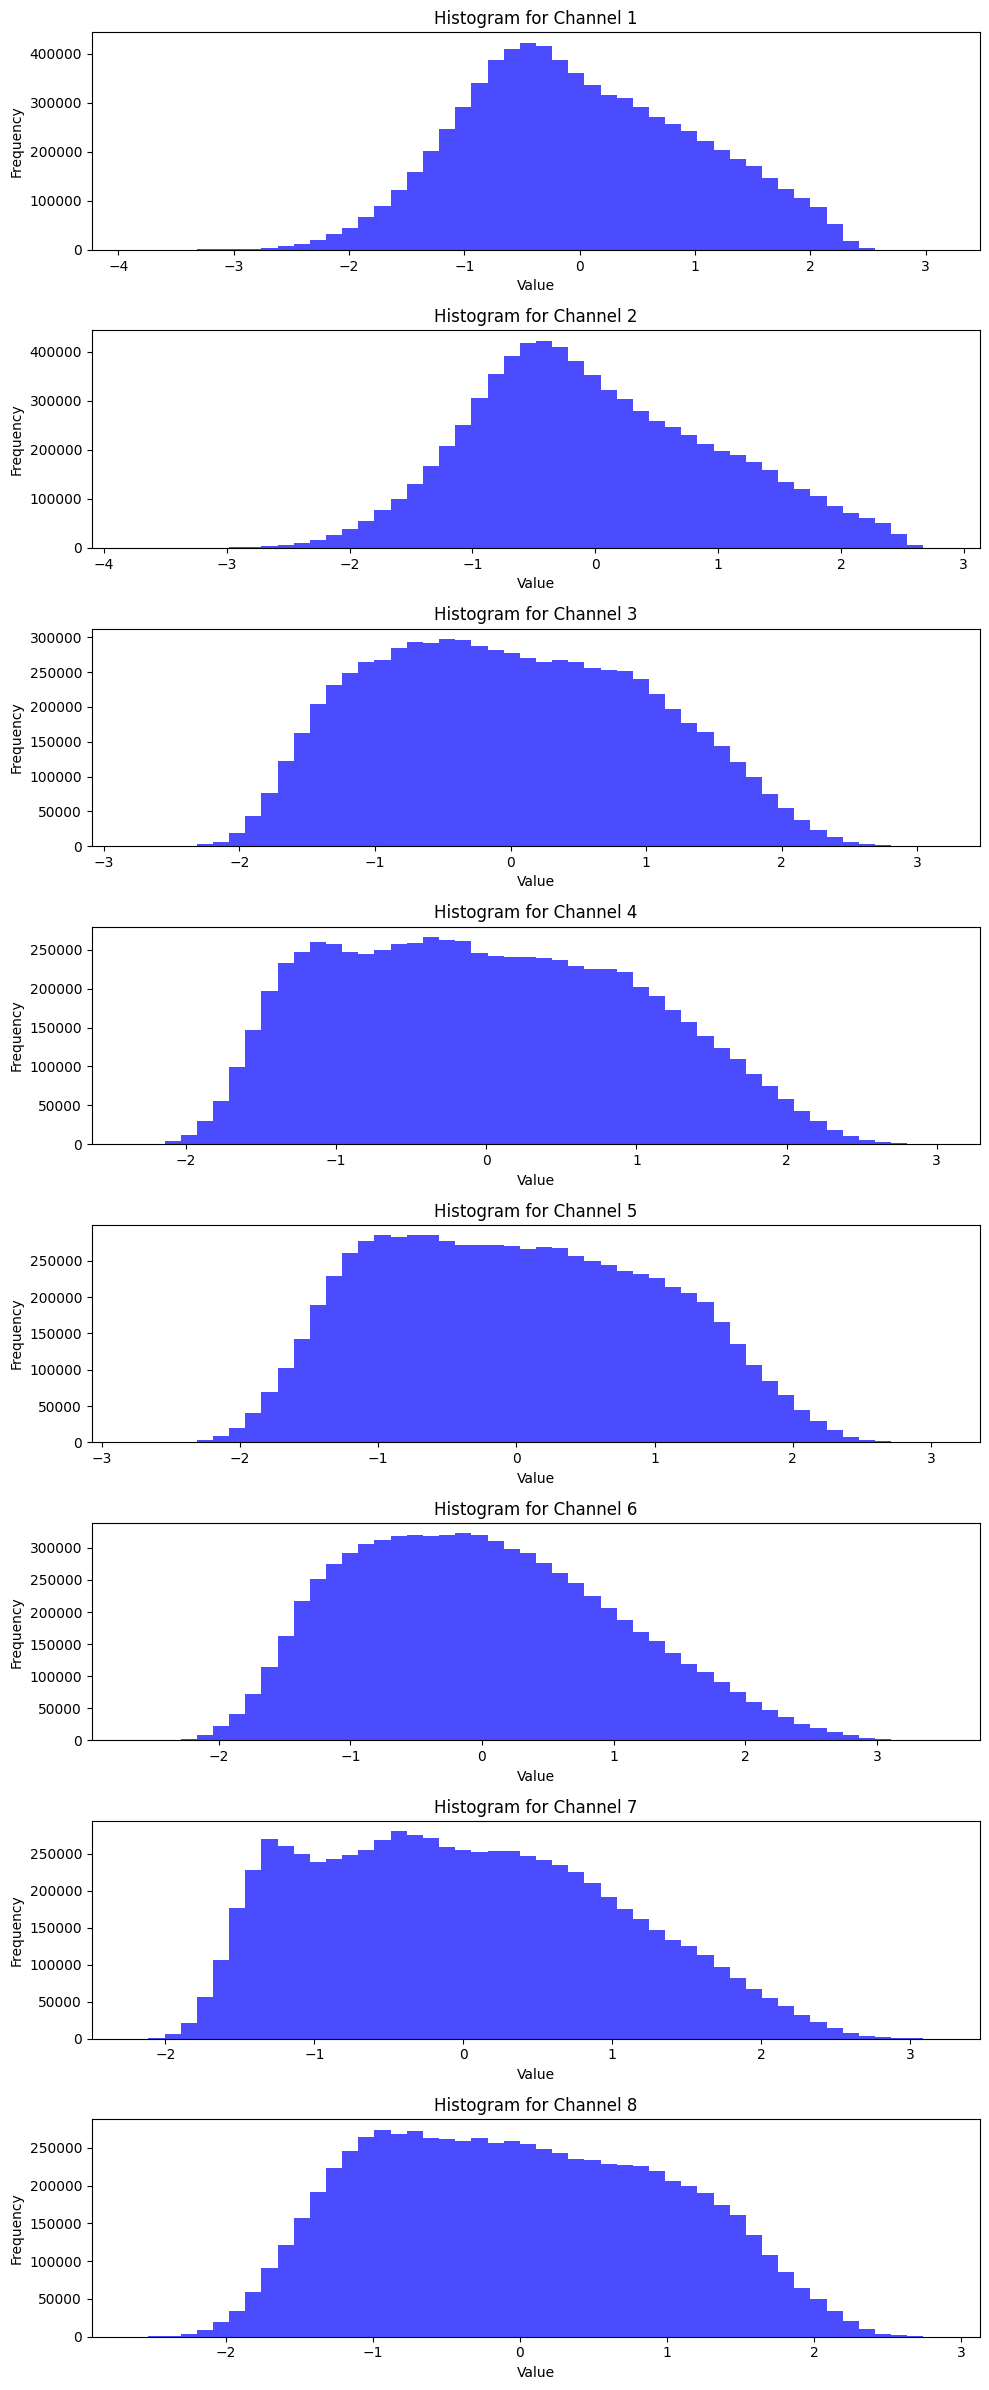

In [11]:
# --- Histograms of Input Features ---
# For each of the 8 selected ERA5 channels, this plots the standardized values.
# Helps verify normalization and highlight if some channels are skewed or non-Gaussian.
n_channels = train_X.shape[-1]

# Create one subplot per channel
fig, axes = plt.subplots(n_channels, 1, figsize=(10, 3 * n_channels))

for i in range(n_channels):
    ax = axes[i]
    # Flatten the channel and plot histogram
    ax.hist(train_X_standardized[..., i].flatten(), bins=50, color='blue', alpha=0.7)
    ax.set_title(f'Histogram for Channel {i+1}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Each subplot represents the distribution of one input climate feature after standardization. These features include temperature, humidity, soil moisture, etc. The well-normalized channels should roughly center around 0 with symmetric spread, and skewed or non-normal distributions may suggest non-linear relationships or that transformations (e.g., log-scaling) might be helpful in future work. From these plots it is clear that the channels are well-normalized, as they are roughly centered around 0.

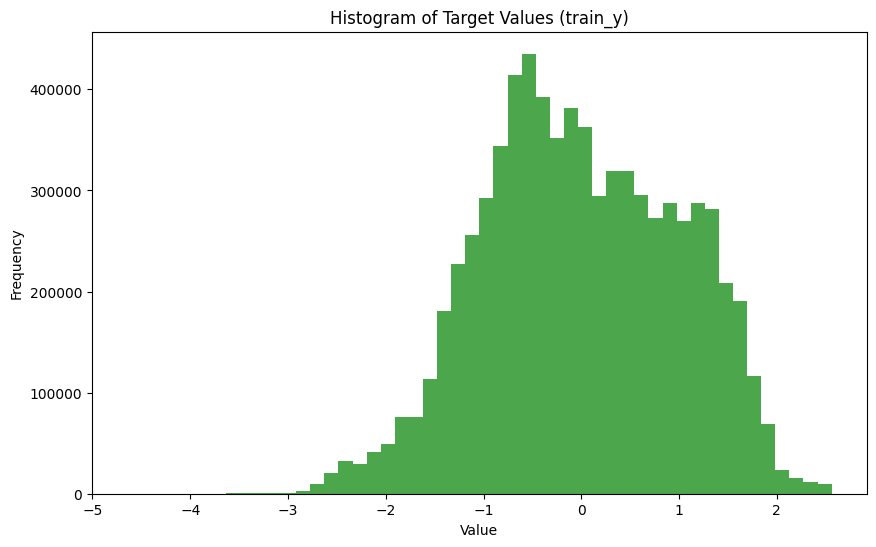

In [12]:
# --- Histogram for Target Variable (SPEI) ---
# This shows the distribution of the standardized target variable (SPEI).
# It allows us to check for skewness, outliers, or truncation in the target.
plt.figure(figsize=(10, 6))
plt.hist(train_y_standardized.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histogram of Target Values (train_y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

This histogram shows how the standardized SPEI values are distributed in the training set. Since SPEI is standardized, we expect a roughly Gaussian distribution centered around 0. Visual inspection here confirms if the standardization was effective and highlights any heavy tails or asymmetry that could affect model performance.

These histograms confirm that NaNs have been removed or interpolated and standardization worked correctly. We also can verifies that feature magnitudes are comparable across channels, which is important for gradient-based optimization. Any spikes, flat lines, or heavy tails can indicate issues like poor interpolation or outliers in raw data.

## Train/Validation Split

To train and evaluate the model effectively, the dataset is split into a training set (80%) and a validation set (20%). This is a common practice to assess generalization: the model is trained only on the training portion, and its performance is monitored on unseen validation data during each epoch. This helps detect overfitting early and allows tuning based on performance trends without touching the test set, which is reserved for final evaluation. The split is done consistently for both inputs and targets to maintain alignment.

In [13]:
N = train_X_standardized.shape[0]
split_idx = int(N * 0.8)                                                              # Define an 80/20 split index for training and validation sets
X_train, X_val = train_X_standardized[:split_idx], train_X_standardized[split_idx:]   # Split standardized input features into training and validation sets
y_train, y_val = train_y_standardized[:split_idx], train_y_standardized[split_idx:]   # Split standardized target labels the same way to preserve alignment

## Custom Loss and Metrics Functions

To evaluate and train the drought forecasting model accurately, especially when working with gridded climate data containing masked or missing values (-9999), we define custom masked loss and metric functions. These functions ensure that only valid values are considered during optimization and evaluation.

Additionally, to make training efficient and robust, we use early stopping and learning rate reduction on plateau, two callbacks that help prevent overfitting and improve convergence.

#### Metrics:
- MAE (Mean Absolute Error): Measures the average magnitude of absolute differences between predicted and actual values. MAE gives a straightforward interpretation of how far predictions are from ground truth on average.

- RMSE (Root Mean Squared Error): Penalizes larger errors more than MAE. It is useful when large prediction errors are especially undesirable (e.g., extreme drought underprediction).

- R² (Coefficient of Determination): Indicates how much of the variance in the target variable is explained by the model. Ranges from 0 (no explanatory power) to 1 (perfect prediction).

- NSE (Nash-Sutcliffe Efficiency): Popular in hydrology. Compares the predictive skill of the model to the skill of simply using the historical mean as a forecast. NSE < 0 means the model performs worse than the mean.



In [15]:
# --- Custom Metric and Loss Computation ---

# Computes standard regression metrics (ignoring NaNs)
def compute_all_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Remove invalid/masked values
    mask = ~np.isnan(y_true_flat) & ~np.isnan(y_pred_flat)
    y_true_clean = y_true_flat[mask]
    y_pred_clean = y_pred_flat[mask]

    # Core metrics
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)

    # NSE: compares to mean model
    nse_numerator = np.sum((y_true_clean - y_pred_clean) ** 2)
    nse_denominator = np.sum((y_true_clean - np.mean(y_true_clean)) ** 2)
    nse = 1 - (nse_numerator / nse_denominator)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "NSE": nse
    }

# Prints metrics in a clean table format
def print_metrics(metrics_dict, title="Test Set Metrics"):
    print(f"\n{title}:")
    print("-" * (len(title) + 1))
    for k, v in metrics_dict.items():
        if isinstance(v, (np.float32, np.float64, float)):
            print(f"{k:20}: {v:.4f}")
        else:
            print(f"{k:20}: {v}")


#### Masked Loss Functions for Missing Values:
These custom functions compute loss or evaluation metrics only on valid entries (i.e., not equal to -9999 and not NaN). This is crucial for gridded reanalysis data where missing points are common.

In [16]:
# --- Masked Loss: Mean Squared Error ---
def masked_mse(mask_value=-9999.0):
    def loss_fn(y_true, y_pred):
        # Mask for valid values
        mask = tf.cast(
            tf.logical_and(y_true != mask_value, ~tf.math.is_nan(y_true)),
            y_pred.dtype
        )
        sq_err = tf.square(y_true - y_pred) * mask
        return tf.math.divide_no_nan(tf.reduce_sum(sq_err), tf.reduce_sum(mask))
    return loss_fn

# -- Masked RMSE --
def masked_rmse(mask_value=-9999.0):
    def metric_fn(y_true, y_pred):
        mask = tf.cast(
            tf.logical_and(y_true != mask_value, ~tf.math.is_nan(y_true)),
            y_pred.dtype
        )
        sq_err = tf.square(y_true - y_pred) * mask
        mse = tf.math.divide_no_nan(tf.reduce_sum(sq_err), tf.reduce_sum(mask))
        return tf.sqrt(mse)
    return metric_fn

# --- Masked MAE ---
def masked_mae(mask_value=-9999.0):
    def metric_fn(y_true, y_pred):
        mask = tf.cast(
            tf.logical_and(y_true != mask_value, ~tf.math.is_nan(y_true)),
            y_pred.dtype
        )
        abs_err = tf.abs(y_true - y_pred) * mask
        return tf.math.divide_no_nan(tf.reduce_sum(abs_err), tf.reduce_sum(mask))
    return metric_fn

#### Training History Plotter:
This function helps visualize how training and validation loss/metrics evolve over time, allowing you to diagnose overfitting, underfitting, or convergence issues.

In [17]:
def plot_training_history(history):
    """
    Plots training/validation loss and masked RMSE evolution during training.
    """
    plt.figure(figsize=(14, 6))

    metrics = ['metric_fn', 'loss']  # Replace 'metric_fn' with the actual metric key used
    titles = ['Masked RMSE', 'Total Loss']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 2, i)
        plt.plot(history.history[metric], label=f'Train {titles[i-1]}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {titles[i-1]}')
        plt.title(f'{titles[i-1]} Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(titles[i-1])
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


#### Training Callbacks
These callbacks monitor validation performance and help the model train efficiently without overfitting.

In [ ]:
# --- Early Stopping ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',                             # Watch validation loss
    patience=20,                                    # Wait 20 epochs before stopping
    restore_best_weights=True                       # Revert to best model observed on val_loss
)

# --- Learning Rate Decay ---
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',                             # Watch validation loss
    factor=0.5,                                     # Halve the learning rate when triggered
    patience=2,                                     # Wait 2 epochs without improvement
    min_lr=1e-6                                     # Set a minimum LR floor to prevent it becoming too small
)

# ConvLSTM Regression Model

The following Convolutional Long Short-Term Memory (ConvLSTM) model is designed to forecast the SPEI over a spatial grid in Australia. The model takes as input sequences of daily ERA5 reanalysis variables, aggregated into a five-dimensional tensor of shape `(31, 20, 20, 8)`, where 31 denotes the number of daily time steps, `20×20` represents the spatial resolution, and 8 corresponds to the number of meteorological input channels.

This architecture is inspired by the work of Shi et al. (1), which introduced the ConvLSTM structure for precipitation nowcasting. In line with this framework, the model uses stacked `ConvLSTM2D` layers, each with a `3×3` kernel, `tanh` activation, same padding, and `return_sequences=True`, allowing it to preserve temporal information across the full sequence. These layers learn complex spatiotemporal dynamics associated with drought development.

To stabilize training and improve generalization, each ConvLSTM block is followed by `BatchNormalization` and Dropout layers. A subsequent Conv3D bottleneck with a `1×1×1` kernel compresses high-dimensional outputs, followed by a `LeakyReLU` activation to retain non-linearity while mitigating vanishing gradients. The final prediction is generated by a `Conv3D` layer with a `3×3×3` kernel and linear activation, producing continuous-valued SPEI estimates across all spatial and temporal dimensions.

The model is trained using the `Adam` optimizer with a learning rate of 0.0003. A custom masked MSE loss function is used to account for missing values (masked as -9999), ensuring that loss and metric calculations reflect only valid data. Masked RMSE and masked MAE are tracked during training. Early stopping and learning rate scheduling are employed to improve convergence and avoid overfitting, with training halted after 20 epochs of stagnant validation loss and learning rate halved when no improvement is seen over 2 epochs.

In [19]:
# --- Input Layer ---
# Input shape: (time_steps=31, width=20, height=20, channels=8)
input_layer = Input(shape=(31, 20, 20, 8))

# --- ConvLSTM Block 1 ---
# First ConvLSTM2D layer to begin modeling spatiotemporal dependencies
x = ConvLSTM2D(
    filters=64,                 # Number of output feature maps
    kernel_size=3,              # 3x3 spatial filter
    padding='same',             # Keep spatial dimensions unchanged
    return_sequences=True,      # Maintain sequence over time for next layer
    activation='tanh',          # Activation function per Shi et al. (2015)
    kernel_regularizer=regularizers.l2(1e-4)  # L2 regularization to reduce overfitting
)(input_layer)
x = BatchNormalization()(x)     # Normalize activations to stabilize training
x = Dropout(0.2)(x)             # Dropout to regularize and prevent overfitting

# --- ConvLSTM Block 2 ---
# Second ConvLSTM2D layer to deepen the temporal modeling
x = ConvLSTM2D(
    filters=64,
    kernel_size=3,
    padding='same',
    return_sequences=True,
    activation='tanh',
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# --- ConvLSTM Bottleneck Block ---
# Third ConvLSTM2D layer with fewer filters for feature compression
x = ConvLSTM2D(
    filters=32,
    kernel_size=3,
    padding='same',
    return_sequences=True,
    activation='tanh',
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# --- Conv3D Bottleneck ---
# A 1x1x1 convolution to reduce dimensionality and apply nonlinearity
x = Conv3D(
    filters=16,
    kernel_size=(1, 1, 1),
    padding='same'
)(x)
x = LeakyReLU(alpha=0.1)(x)  # Leaky ReLU activation helps with gradient flow

# --- Final Conv3D Output Layer ---
# Outputs a single continuous value per spatiotemporal location (regression)
output = Conv3D(
    filters=1,
    kernel_size=(3, 3, 3),
    padding='same',
    activation='linear'  # Linear activation for regression (SPEI prediction)
)(x)

# --- Model Compilation ---
model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Adam optimizer
    loss=masked_mse(),                # Custom masked MSE loss (ignores missing values)
    metrics=[masked_rmse(), masked_mae()]  # Track RMSE and MAE, also with masking
)

# --- Model Summary ---
model.summary()  # Prints a summary of all layers and parameters


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 31, 20, 20, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 31, 20, 20, 64) │       166,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 20, 20, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 20, 20, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 31, 20, 20, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 20, 20, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 20, 20, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 31, 20, 20, 32) │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 20, 20, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 20, 20, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 31, 20, 20, 16) │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 31, 20, 20, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 31, 20, 20, 1)  │           433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,633 (2.19 MB)

 Trainable params: 573,313 (2.19 MB)

 Non-trainable params: 320 (1.25 KB)

In [20]:
# --- Training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,                                # Allows for more epochs; early stopping will cut it off if needed
    batch_size=16,                             # Increased batch size reduces gradient noise and stabilizes ConvLSTM training
    callbacks=[early_stopping, reduce_lr],     # Early Stopping & Learning Rate Decay
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 638ms/step - loss: 1.6177 - metric_fn: 1.2556 - metric_fn_1: 1.0090 - val_loss: 0.8050 - val_metric_fn: 0.8401 - val_metric_fn_1: 0.7315 - learning_rate: 3.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - loss: 1.2471 - metric_fn: 1.1039 - metric_fn_1: 0.9055 - val_loss: 0.7673 - val_metric_fn: 0.8253 - val_metric_fn_1: 0.7172 - learning_rate: 3.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - loss: 1.0504 - metric_fn: 1.0122 - metric_fn_1: 0.8241 - val_loss: 0.7347 - val_metric_fn: 0.8098 - val_metric_fn_1: 0.7030 - learning_rate: 3.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - loss: 1.0562 - metric_fn: 1.0134 - metric_fn_1: 0.8199 - val_loss: 0.7635 - val_metric_fn: 0.8235 - val_metric_fn_1: 0.7155 - learning_rate: 3.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - loss: 0.9937 - metric_fn: 0.9833 - metric_fn_1: 0.7988 - val_loss: 0.6838 - val_metric_fn: 0.7920 - val_metric_fn_1:

## Model Evaluation (Regression)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
Pearson correlation (Validation Set): 0.4430

Validation Set Metrics (Unstandardized):
----------------------------------------
MAE                 : 0.7053
RMSE                : 0.8539
R2                  : 0.1904
NSE                 : 0.1904


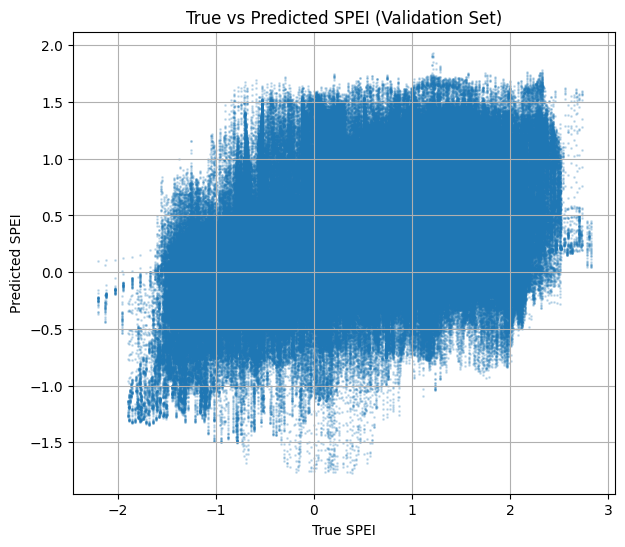

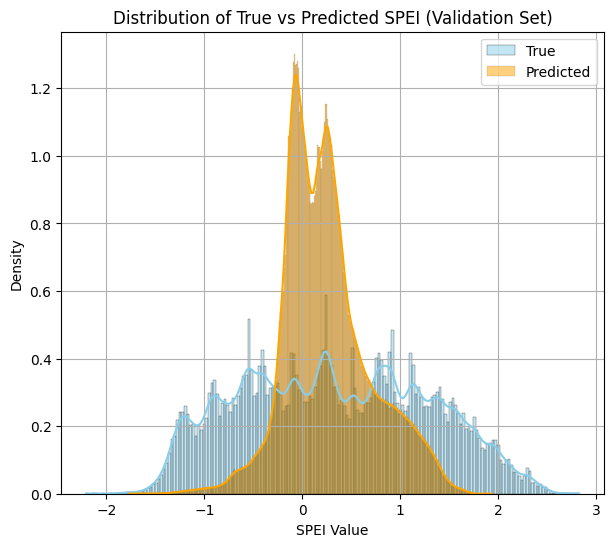

In [22]:
# --- Validation Evaluation ---

# --- Predict on validation data ---
# Model outputs predictions in standardized form with shape (31, 20, 20)
y_pred_val = model.predict(X_val).squeeze()       # Remove extra dimension
y_val_flat = y_val.squeeze()                      # True values

# --- Flatten predictions and true values ---
# Flatten to 1D arrays for metric computation
y_val_flat = y_val_flat.flatten()
y_pred_flat = y_pred_val.flatten()

# --- Invert Standardization ---
# Convert predictions and targets back to original SPEI scale
y_pred_inv_val = scaler_y.inverse_transform(y_pred_flat.reshape(-1, 1)).flatten()
y_true_inv_val = scaler_y.inverse_transform(y_val_flat.reshape(-1, 1)).flatten()

# --- Pearson Correlation ---
# Measures linear association between predicted and actual values
corr_val, _ = pearsonr(y_true_inv_val, y_pred_inv_val)
print(f"Pearson correlation (Validation Set): {corr_val:.4f}")

# --- Compute Regression Metrics (MAE, RMSE, R², NSE) ---
val_metrics = compute_all_metrics(y_true_inv_val, y_pred_inv_val)
print_metrics(val_metrics, title="Validation Set Metrics (Unstandardized)")

# --- Scatter Plot (True vs Predicted) ---
# Visual inspection of prediction quality
valid_mask_val = ~np.isnan(y_true_inv_val)  # Filter out any NaNs
plt.figure(figsize=(7, 6))
plt.scatter(
    y_true_inv_val[valid_mask_val],
    y_pred_inv_val[valid_mask_val],
    alpha=0.2, s=1
)
plt.xlabel("True SPEI")
plt.ylabel("Predicted SPEI")
plt.title("True vs Predicted SPEI (Validation Set)")
plt.grid(True)
plt.show()

# --- Distribution Comparison ---
# Overlay KDE plots of true vs predicted values
plt.figure(figsize=(7, 6))
sns.histplot(
    y_true_inv_val[valid_mask_val],
    color='skyblue', label='True', kde=True, stat='density'
)
sns.histplot(
    y_pred_inv_val[valid_mask_val],
    color='orange', label='Predicted', kde=True, stat='density'
)
plt.title("Distribution of True vs Predicted SPEI (Validation Set)")
plt.xlabel("SPEI Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

#### Validation Evaluation:
- The ConvLSTM model shows moderate predictive ability on the validation set. A Pearson correlation of 0.443 suggests that the model captures some underlying relationship between input variables and SPEI, but its linear association is limited.

- With a MAE of 0.705 and RMSE of 0.854, the model's predictions exhibit moderate average error, though some larger deviations are penalized more heavily. The R² and NSE values of 0.19 indicate that the model explains about 19% of the variance in SPEI values—better than predicting the mean, but still leaving much room for improvement.

- Visualizations show that predicted values are tightly concentrated around the mean, underestimating extreme negative values (i.e., severe droughts). The model struggles to capture the tails of the SPEI distribution, which is critical for operational drought forecasting.

Overall, the model performs acceptably on the validation set, but its tendency to regress to the mean limits its effectiveness in identifying high-impact drought events. The test set results, discussed next, will provide insight into how well these patterns hold in truly unseen data.



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step
Pearson correlation (Test Set): 0.1087

Test Set Metrics (Unstandardized):
----------------------------------
MAE                 : 1.4220
RMSE                : 1.6604
R2                  : -2.2194
NSE                 : -2.2194


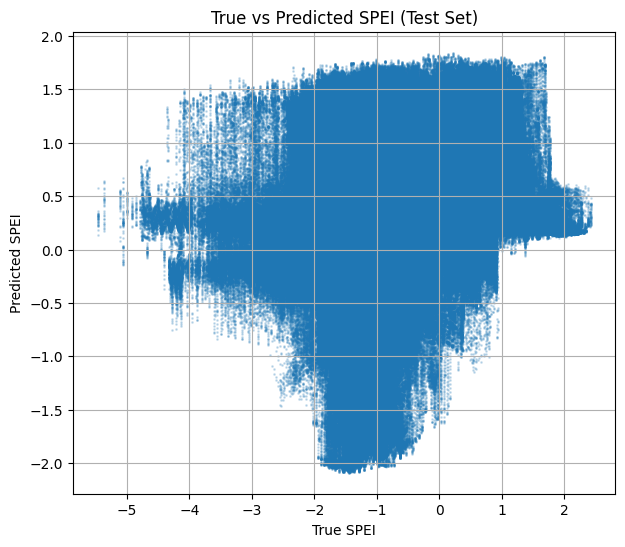

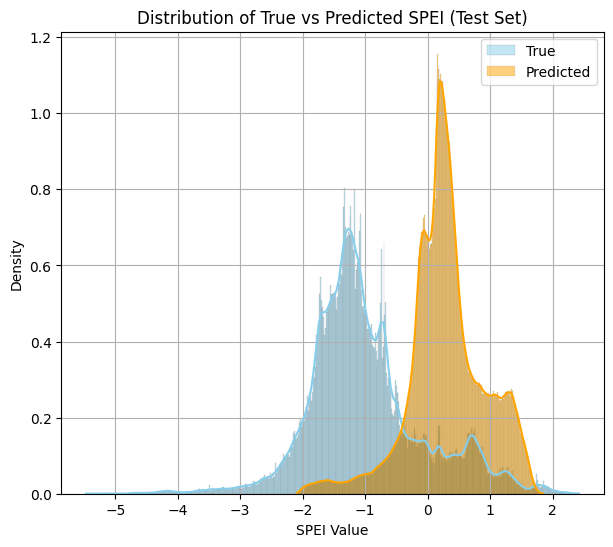

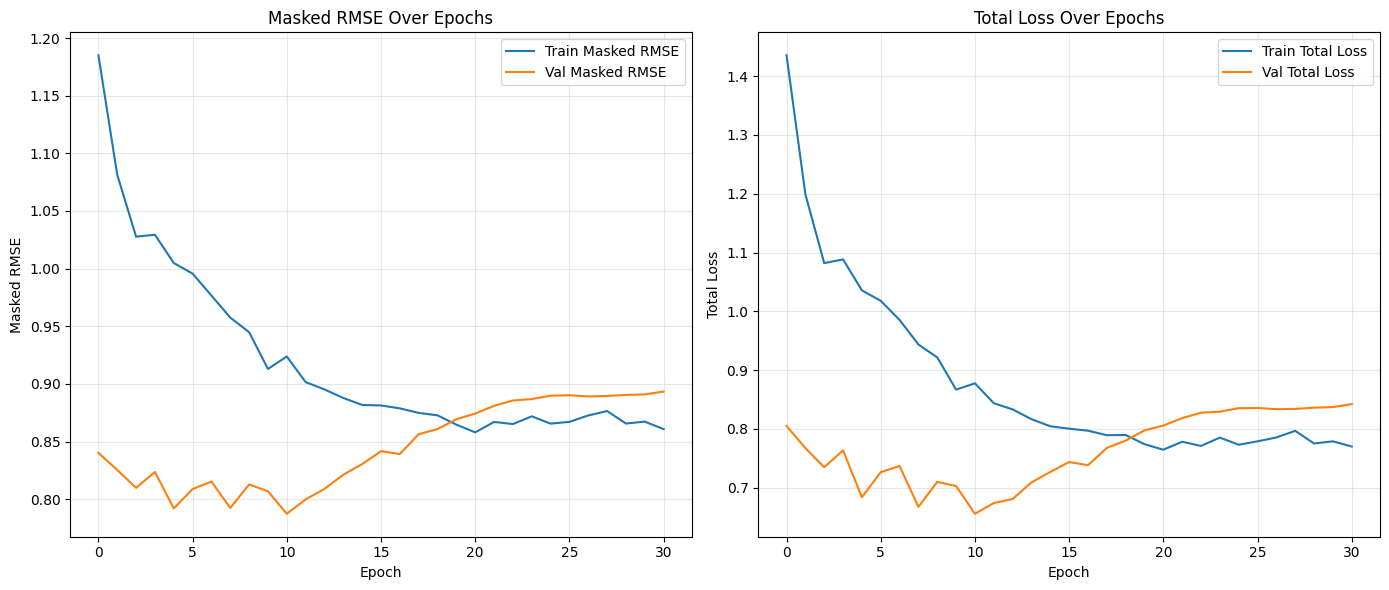

In [23]:
# --- Test Set Evaluation ---

# --- Predict on standardized test data ---
# The model outputs standardized SPEI predictions with shape (31, 20, 20)
y_pred_test = model.predict(test_X_standardized).squeeze()
test_y_flat = test_y_standardized.squeeze()  # True standardized values

# --- Flatten predictions and true labels ---
# Flatten into 1D arrays for comparison
y_pred_flat = y_pred_test.flatten()
y_true_flat = test_y_flat.flatten()

# --- Invert Standardization ---
# Convert predictions and true values back to the original SPEI scale
y_pred_inv_test = scaler_y.inverse_transform(y_pred_flat.reshape(-1, 1)).flatten()
y_true_inv_test = scaler_y.inverse_transform(y_true_flat.reshape(-1, 1)).flatten()

# --- Pearson Correlation ---
# Assess linear correlation between predicted and true values
corr_test, _ = pearsonr(y_true_inv_test, y_pred_inv_test)
print(f"Pearson correlation (Test Set): {corr_test:.4f}")

# --- Compute Performance Metrics (Unstandardized) ---
# Includes MAE, RMSE, R², NSE
test_metrics = compute_all_metrics(y_true_inv_test, y_pred_inv_test)
print_metrics(test_metrics, title="Test Set Metrics (Unstandardized)")

# --- Scatter Plot (Predicted vs True SPEI) ---
# Visualize how well predictions match actual values
valid_mask_test = ~np.isnan(y_true_inv_test)  # Mask NaNs
plt.figure(figsize=(7, 6))
plt.scatter(
    y_true_inv_test[valid_mask_test],
    y_pred_inv_test[valid_mask_test],
    alpha=0.2, s=1
)
plt.xlabel("True SPEI")
plt.ylabel("Predicted SPEI")
plt.title("True vs Predicted SPEI (Test Set)")
plt.grid(True)
plt.show()

# --- Distribution Comparison ---
# Compare distributions using KDEs
plt.figure(figsize=(7, 6))
sns.histplot(
    y_true_inv_test[valid_mask_test], color='skyblue', label='True',
    kde=True, stat='density'
)
sns.histplot(
    y_pred_inv_test[valid_mask_test], color='orange', label='Predicted',
    kde=True, stat='density'
)
plt.title("Distribution of True vs Predicted SPEI (Test Set)")
plt.xlabel("SPEI Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Training History ---
# Visualize how loss and RMSE evolved during training
plot_training_history(history)


#### Test Set Evaluation:

The performance of the model on the test set reveals important insights into its generalization ability and limitations:

- Pearson Correlation (0.1087):
    - The low correlation between true and predicted SPEI values suggests the model struggles to capture the underlying linear relationship in unseen data. While it may have learned some structure during training, it fails to generalize effectively to new, out-of-sample patterns.

- MAE (1.4220) and RMSE (1.6604):
    - These relatively high error metrics indicate that the model often makes large absolute and squared errors when predicting SPEI. RMSE being notably higher than MAE also highlights the presence of larger individual outliers in the prediction errors.

- R² / NSE (-2.2194):
    - Both R² and the Nash–Sutcliffe Efficiency (NSE) are negative, meaning the model performs significantly worse than a naive model that simply predicts the mean of the target variable. This is a strong indicator of poor predictive performance on the test data.

Visual Interpretation
- Scatter Plot:
    - The scatter plot of true vs. predicted SPEI shows considerable dispersion with a flattened shape, especially in the drought-prone (negative SPEI) region. The lack of vertical alignment suggests the model is underfitting extreme negative values.

- Distribution Plot:
    - The predicted SPEI distribution is sharply centered around zero, showing a strong bias toward the mean. This "regression to the mean" behavior confirms that the model is not capturing the tails of the SPEI distribution well—particularly severe droughts (e.g., SPEI < -2), which are critically important for climate risk applications.

- Training Curves:
    - The masked RMSE and total loss plots show the model continues to improve on the training set but stagnates or worsens on the validation set after a point, suggesting overfitting. This further explains the model's degraded performance on the test set, as it memorized training patterns without learning robust general features.

The model's inability to generalize to the test year (2002) highlights a major temporal generalization challenge. The sharp central bias in predictions suggests model underconfidence in rare events, especially extreme droughts.

#### Experimentation:
We conducted extensive experimentation on model architecture, data preprocessing, loss masking, activation functions, normalization strategies, and regularization techniques to improve the performance of our ConvLSTM regression model. Despite considerable architectural tuning, the models consistently struggled to generalize well to unseen test data.

Input Data
- We experimented extensively with the number and selection of input channels. Ultimately, restricting inputs to only those channels that showed positive correlations with the target (SPEI) proved most beneficial for model performance.

Target Variable (SPEI)
- To match typical climatic ranges, the SPEI target was clipped to the interval
[−3,3]. However, this did not improve performance. We applied a `StandardScaler` after clipping to prevent data leakage, but again observed no gain in predictive accuracy.

Initial Model Architecture
- Our base model consisted of three stacked `ConvLSTM2D` layers with `return_sequences=True`, following the architecture proposed by Shi et al. (1). Each ConvLSTM block was followed by batch normalization and dropout. A final `Conv3D` layer performed regression over the spatiotemporal volume. Intermediate layers used `tanh` activations, with a `linear` activation in the output layer.

##### Experimental Variations

We tested a wide range of architectural and training adjustments, including:

- Regularization: L2 weight decay ranging from 1e-3 to 1e-4 applied to ConvLSTM and Conv3D layers.

- Dropout Techniques: Compared standard Dropout to SpatialDropout3D.

- Activation Functions: Evaluated `tanh`, `ReLU`, `leaky_ReLU`, and `linear` in the final layer. We also tested rescaling `tanh` outputs post-prediction for clipped targets.

- Normalization Strategies: Compared `BatchNormalization` and `LayerNormalization`.

- Activation Placement: Tested both pre-activation and post-activation configurations.

- Model Depth and Capacity: Increased ConvLSTM depth to 3–4 layers, introduced Conv3D bottlenecks with `1×1×1` kernels, and applied compression by reducing filters in later layers.

- Residual Connections: Implemented skip connections between early and late ConvLSTM layers with Conv3D projection layers for filter dimension alignment.

- Target Scaling: Reassessed the effect of output clipping and trained models both with and without standardization and loss masking.

*The architecture seen above produced the best results among all configurations tested.*

Despite the variety of approaches, regression performance on the test set remained poor:
- Test R2: Consistently negative (e.g., −1.6 to −2.5)
- Pearson Correlation: Low (e.g., 0.08 to 0.16)


##### Observations and Insights 
- The regression task was highly sensitive to small shifts in the target distribution.
- Clipping stabilized gradients but introduced bias.
- `Tanh` and `leaky_ReLU` outperformed `ReLU` in intermediate layers.
- Overfitting remained a persistent challenge, even with dropout, regularization, and early stopping.
- Masked loss functions were essential to properly handle NaN-padded spatial regions.

Given the limited predictive power and high variance of the regression models, we also introduce to a binary classification task. This pivot aimed to better capture categorical drought severity levels (e.g., SPEI < −1) and reduce sensitivity to small-scale noise in the continuous target variable.

This addition was informed by valuable lessons on model behavior, data sensitivity, and architectural limitations in spatiotemporal regression. While regression performance fell short of practical utility, the experimentation process provided a solid foundation for designing a more robust classification model.

## Binary Classification Model

To complement our regression approach for predicting continuous SPEI values, we implemented a binary classification model to predict the presence or absence of drought conditions. This approach simplifies the problem by asking a yes/no question: Is this location experiencing drought?

A threshold of SPEI < -1 was chosen as the binary cutoff based on widely accepted definitions from the Global SPEI database and climate literature. This corresponds to moderate drought or worse and is a common operational standard.

In [24]:
# --- Data Preprocessing for Classification

# Convert continuous target into binary labels: 1 = drought, 0 = no drought
binary_train_y = (train_y < -1).astype(int)
binary_test_y = (test_y < -1).astype(int)

# Split into training and validation sets
N = binary_train_y.shape[0]
split_idx = int(N * 0.8)
y_train_class = binary_train_y[:split_idx]
y_val_class = binary_train_y[split_idx:]


In [25]:
# --- Binary ConvLSTM Model ---
input_layer = Input(shape=(31, 20, 20, 8))

# --- Input Layer ---
input_layer = Input(shape=(31, 20, 20, 8))  # Input shape matches the temporal and spatial grid of ERA5 data

# --- ConvLSTM Block 1 ---
# Learn spatiotemporal features
x = ConvLSTM2D(64, kernel_size=3, padding='same', return_sequences=True,
               activation='tanh')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# --- ConvLSTM Block 2 ---
x = ConvLSTM2D(64, kernel_size=3, padding='same', return_sequences=True,
               activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# --- Bottleneck ---
# Reduce feature dimensionality before output
x = Conv3D(32, kernel_size=(1,1,1), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

# --- Output Layer ---
# Binary classification with sigmoid activation
output = Conv3D(
    filters=1,
    kernel_size=(3, 3, 3),
    padding='same',
    activation='sigmoid'  # Outputs probability of drought at each grid cell
)(x)

model = Model(inputs=input_layer, outputs=output)

# Compile with binary crossentropy and accuracy as metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 31, 20, 20, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 31, 20, 20, 64) │       166,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 20, 20, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 20, 20, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 31, 20, 20, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 31, 20, 20, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 20, 20, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 31, 20, 20, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 31, 20, 20, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 31, 20, 20, 1)  │           865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464,769 (1.77 MB)

 Trainable params: 464,513 (1.77 MB)

 Non-trainable params: 256 (1.00 KB)

In [28]:
# --- Training ---
history_cls = model.fit(
    X_train, y_train_class,
    validation_data=(X_val, y_val_class),
    epochs=100,                                 # Allows for more epochs; early stopping will cut it off if needed
    batch_size=16,                              # Increased batch size reduces gradient noise and stabilizes ConvLSTM training
    callbacks=[early_stopping, reduce_lr],      # Early Stopping & Learning Rate Decay
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.8400 - loss: 0.3904 - val_accuracy: 0.9139 - val_loss: 0.3032 - learning_rate: 3.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.8728 - loss: 0.3405 - val_accuracy: 0.9093 - val_loss: 0.3044 - learning_rate: 3.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.8746 - loss: 0.3412 - val_accuracy: 0.9116 - val_loss: 0.3102 - learning_rate: 3.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.8660 - loss: 0.3334 - val_accuracy: 0.9099 - val_loss: 0.2849 - learning_rate: 1.5000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.8997 - loss: 0.3020 - val_accuracy: 0.8837 - val_loss: 0.3187 - learning_rate: 1.5000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.8849 - loss: 0.3081 - val_accuracy: 0.8660 - val_loss: 0.3246 - learning_rate: 1.5000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - acc

## Model Evaluation (Binary Classification)

To evaluate the performance of the binary classification model for drought detection (SPEI < –1), a combination of standard metrics is used. Each of these provides unique insight into how well the model distinguishes between drought and non-drought conditions:

- **Accuracy** measures the overall proportion of correctly classified instances (both drought and non-drought). While intuitive, accuracy can be misleading in imbalanced datasets where one class dominates (e.g., droughts are relatively rare). A high accuracy might still mask poor performance in detecting the minority class.

- **Precision** quantifies how often the model’s drought predictions are actually correct. It is defined as the number of true drought predictions divided by all predicted droughts (TP / (TP + FP)). High precision is important when false alarms are costly — for example, triggering unnecessary drought warnings.

- **Recall** (also known as sensitivity or true positive rate) measures the ability of the model to identify actual droughts. It is calculated as TP / (TP + FN), indicating how many real droughts were successfully detected. In drought forecasting, recall is critical because failing to detect an actual drought (a false negative) can have serious social and economic consequences.

- **F1** Score is the harmonic mean of precision and recall, providing a single metric that balances the trade-off between false positives and false negatives. It is particularly useful when the goal is to balance over-warning and under-detection in a practical system.

- **AUC** (Area Under the ROC Curve) reflects the model’s overall ability to distinguish between drought and non-drought across all classification thresholds. Unlike accuracy, AUC is not tied to a fixed threshold (e.g., 0.5), and it is robust to class imbalance. AUC values closer to 1.0 indicate better separability.

- **Confusion Matrix** provides a detailed breakdown of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). This allows visual inspection of model biases — for example, whether the model systematically misses droughts (high FN) or generates too many false alarms (high FP).

Together, these metrics give a holistic view of model behavior and support informed adjustments to model architecture, thresholding, or data preprocessing in future iterations.


In [29]:
def evaluate_binary_classification(y_probs, y_true, set_name="Test Set"):
    """
    Evaluates a binary classification model using predicted probabilities and true binary labels.
    Prints classification metrics and displays a confusion matrix heatmap.

    Parameters:
    - y_probs: predicted probabilities from the model (output of sigmoid layer)
    - y_true: ground truth binary labels
    - set_name: string to label the evaluation set (e.g., "Validation Set", "Test Set")
    """

    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred = (y_probs > 0.5).astype(int)

    # Flatten the arrays to 1D for metric computation
    y_pred_flat = y_pred.flatten()
    y_true_flat = y_true.flatten()

    # Remove invalid entries (e.g., NaNs due to padding/masked areas)
    valid_mask = ~np.isnan(y_true_flat)
    y_pred_flat = y_pred_flat[valid_mask].astype(int)
    y_true_flat = y_true_flat[valid_mask].astype(int)

    # --- Classification report (precision, recall, F1 per class)
    print(f"\n--- {set_name} Classification Report ---")
    print(classification_report(y_true_flat, y_pred_flat, digits=4))

    # --- Manually compute common metrics
    acc = accuracy_score(y_true_flat, y_pred_flat)                # Proportion of correct predictions
    prec = precision_score(y_true_flat, y_pred_flat)              # Precision = TP / (TP + FP)
    rec = recall_score(y_true_flat, y_pred_flat)                  # Recall = TP / (TP + FN)
    f1 = f1_score(y_true_flat, y_pred_flat)                       # Harmonic mean of precision and recall
    auc = roc_auc_score(y_true_flat, y_probs.flatten()[valid_mask])  # AUC from predicted probs

    # Print metrics
    print(f"{set_name} Accuracy : {acc:.4f}")
    print(f"{set_name} Precision: {prec:.4f}")
    print(f"{set_name} Recall   : {rec:.4f}")
    print(f"{set_name} F1 Score : {f1:.4f}")
    print(f"{set_name} AUC      : {auc:.4f}")

    # --- Confusion Matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Drought', 'Drought'],
                yticklabels=['No Drought', 'Drought'])
    plt.title(f"Confusion Matrix ({set_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step

--- Validation Set Classification Report ---
              precision    recall  f1-score   support

           0     0.9134    0.9926    0.9514   1348527
           1     0.0171    0.0014    0.0025    127073

    accuracy                         0.9073   1475600
   macro avg     0.4652    0.4970    0.4769   1475600
weighted avg     0.8362    0.9073    0.8697   1475600

Validation Set Accuracy : 0.9073
Validation Set Precision: 0.0171
Validation Set Recall   : 0.0014
Validation Set F1 Score : 0.0025
Validation Set AUC      : 0.7760


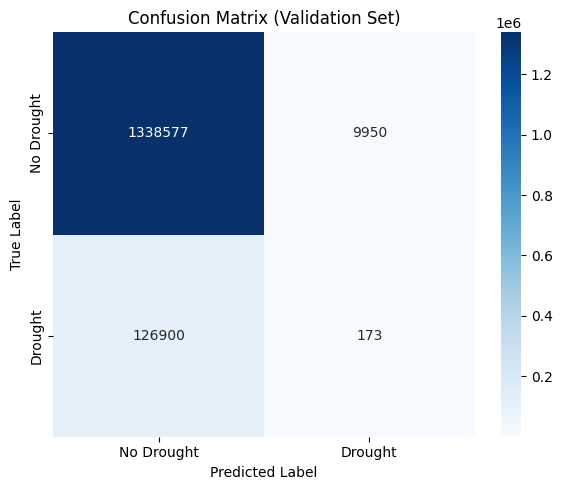

In [30]:
# --- Validation Evaluation ---
y_pred_probs_val = model.predict(X_val).squeeze()
evaluate_binary_classification(y_pred_probs_val, y_val_class.squeeze(), set_name="Validation Set")

#### Validation Evaluation:
The binary ConvLSTM model achieves high overall accuracy (90.73%) on the validation set, largely driven by its correct classification of the dominant class—non-drought (SPEI ≥ -1). However, this accuracy metric is misleading given the extreme class imbalance present in the dataset.

While the precision for the drought class (class 1) is only 1.71%, it indicates that when the model does predict a drought, it is correct very infrequently. Even more concerning is the recall of 0.14%, which reflects the model’s inability to identify actual drought cases. This results in a very low F1 score of 0.25%, confirming that the model fails to detect drought conditions effectively.

The AUC of 0.7760 suggests that the model has some capacity to rank drought cases above non-drought cases when viewed probabilistically. However, this ranking capability is not being translated into effective classification at the default threshold of 0.5.

This pattern is consistent with what’s expected when training on highly imbalanced datasets without appropriate corrective measures (e.g., class weighting, oversampling, or threshold tuning). The model has likely learned to prioritize overall accuracy by predicting “non-drought” in nearly all cases, thereby avoiding false positives at the cost of many false negatives.

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step

--- Test Set Classification Report ---
              precision    recall  f1-score   support

           0     0.4241    0.9612    0.5885   1020806
           1     0.7203    0.0712    0.1296   1434394

    accuracy                         0.4412   2455200
   macro avg     0.5722    0.5162    0.3591   2455200
weighted avg     0.5972    0.4412    0.3204   2455200

Test Set Accuracy : 0.4412
Test Set Precision: 0.7203
Test Set Recall   : 0.0712
Test Set F1 Score : 0.1296
Test Set AUC      : 0.5788


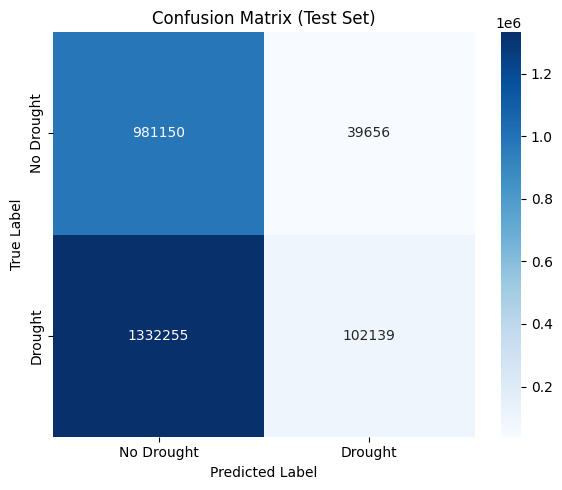

In [31]:
# --- Test Evaluation ---
y_pred_probs_test = model.predict(test_X_standardized).squeeze()
evaluate_binary_classification(y_pred_probs_test, binary_test_y.squeeze(), set_name="Test Set")

The model achieves a test accuracy of 44.12%, which, while seemingly modest, is not the most informative measure given the class imbalance inherent in drought detection. Instead, we focus on precision, recall, F1 score, and AUC to assess model quality.

- The model exhibits high precision (72.03%) for the drought class (SPEI < –1), meaning that when a drought is predicted, it is correct the majority of the time. This suggests a low false positive rate, which is beneficial in avoiding unnecessary drought alarms.

- However, recall is only 7.12%, indicating that the model correctly identifies fewer than 1 in 10 actual drought cases. This imbalance results in an F1 score of just 12.96%, reflecting poor balance between precision and recall.

- The AUC of 0.5788 is only slightly above random guessing, highlighting the model’s limited ability to discriminate between drought and non-drought cases across varying decision thresholds.

This behavior is typical of an overly conservative model that prioritizes confidence over coverage—predicting droughts only when very certain, at the cost of missing many true drought events. For early warning systems, this tradeoff is problematic, as missing a real drought (false negative) can be more damaging than issuing a false alarm.

The binary classification approach was introduced in response to limitations observed in the regression model, which regressed heavily toward the mean and failed to capture the extremes of the SPEI distribution—especially during severe drought events. By reframing the task as a binary classification problem (drought vs. no drought), the model could more explicitly focus on rare, high-impact events. The ConvLSTM architecture was adapted to this task using a sigmoid-activated Conv3D output and binary cross-entropy loss.

Extensive experimentation was undertaken to refine this model. Architectural changes such as deeper ConvLSTM stacks, dropout regularization, and spatial-temporal bottlenecks were tested. Additionally, learning rate schedules and early stopping were incorporated to prevent overfitting. Despite these efforts, the extreme class imbalance and the limited number of strong drought events in the training data constrained recall performance.

In summary, the final binary ConvLSTM classifier represents the most optimized and stable configuration developed in the ConvLSTM portion of this project. Its high precision makes it suitable in contexts where false alarms must be avoided, but its low recall limits operational utility in early warning systems. 

Future work could focus on improving drought event detection through advanced imbalance strategies (e.g., focal loss, SMOTE, reweighting), ordinal classification to reflect drought severity, or hybrid ensemble methods. While challenges remain, this model lays a strong foundation for more robust climate-driven drought forecasting solutions.

**Refrences**

1. Shi, X., Chen, Z., Wang, H., Yeung, D.-Y., Wong, W.-K., & Woo, W.-C. (2015).
Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting.
arXiv preprint arXiv:1506.04214.
Available at: https://arxiv.org/abs/1506.04214